## * Import Data Into Project * ##

In [ ]:
# Import libraries
import os
import cv2
import time
import random
import numpy as np
import tensorflow as tf
from pathlib import Path
from keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt


In [2]:
# paths for data

train_dir = "C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/train"
test_dir = "C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/val"
val_dir = "C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/test"



In [13]:
# funcs to import images

def process_image_batches(img_paths, processed_images, img_num):
    """ Import images from the specified directory """
    
    for i in range(0, img_num):
        img_path = cv2.imread(img_paths[i])
        img = cv2.resize(img_path, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.expand_dims(img, axis = 2)
        img = img / 255.0
        processed_images.append(img)
        completed_percentage = (i / img_num) * 100
        if completed_percentage in [25, 50, 75, 100]:
            print(f"Images processed: {i} ({round(completed_percentage)}%)")




def import_and_process_images(img_dir, img_num = int):
    """ Import images from the specified directory """
    start = time.time()
    processed_images = []
    img_paths = []

    for root, dirs, files in os.walk(img_dir):
            for file in files:
                if file.endswith(".JPEG"):
                     img_paths.append(os.path.join(root, file))

    random.shuffle(img_paths)
    process_image_batches(img_paths, processed_images, img_num)
                          
    end = time.time()
    print(f"Function processed {img_dir} in {round(end - start)} seconds.\n")
    return processed_images

In [ ]:
# import images

train_images = import_and_process_images(train_dir, 35000)
test_images = import_and_process_images(test_dir, 4750)
val_images = import_and_process_images(val_dir, 4750)


Images processed: 8750 (25%)
Images processed: 17500 (50%)
Images processed: 26250 (75%)
Function processed C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/train in 413 seconds.

Images processed: 2375 (50%)
Function processed C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/val in 60 seconds.



## * Inspect Images * ##

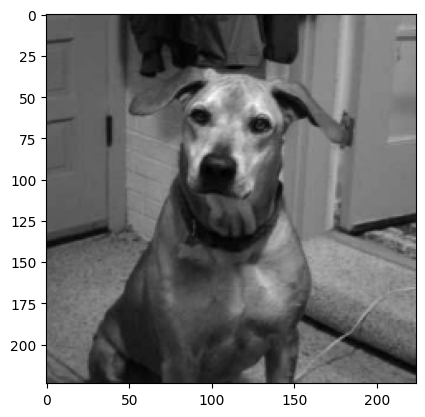

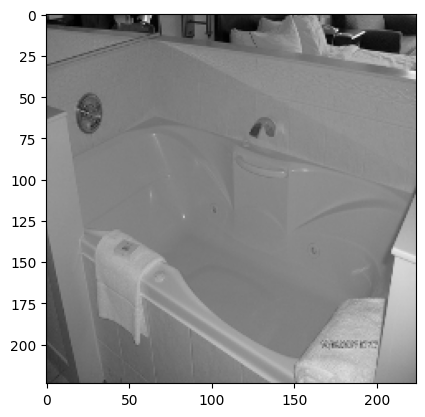

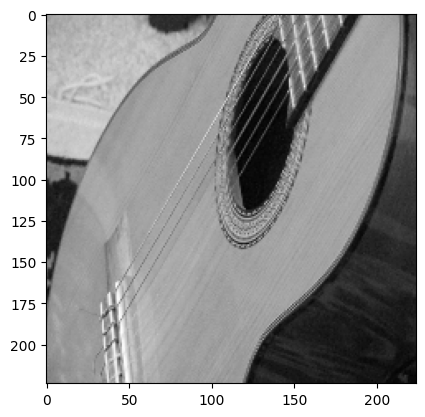

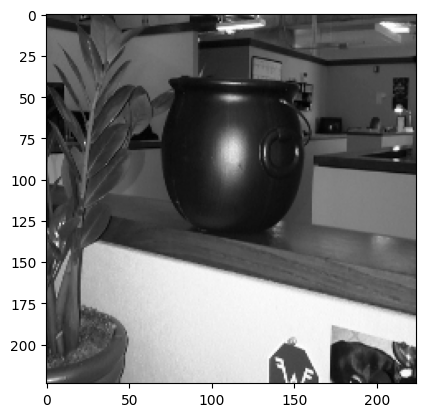

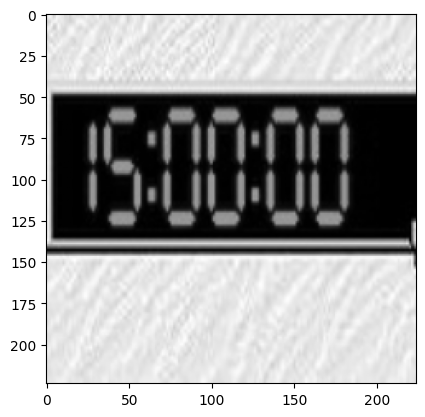

In [5]:
# view images
def view_image_array(image_arrays, n):
    """ View an image array """
    for i in range(0, n):
        plt.imshow(image_arrays[i], cmap='gray')
        plt.show()

view_image_array(train_images, 5)

In [6]:
# check the shape of images
for i in range(0, 5):
    print(train_images[i].shape)

(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)


## 1) Perform Object Detection ##

In [7]:
# define edge detection function

def edge_detection(image_arr, low_threshold = 100, high_threshold = 200):
    """ Detect edges in an image """
    # remove single channel dimension
    image_arr = image_arr.squeeze()
    # convert to uint8
    if image_arr.dtype != np.uint8:
        image_arr = (image_arr * 255).astype(np.uint8)
    # detect edges
    edges = cv2.Canny(image_arr, low_threshold, high_threshold)
    return edges

In [8]:
# perform edge detection on images
train_edge_images = [edge_detection(image) for image in train_images]

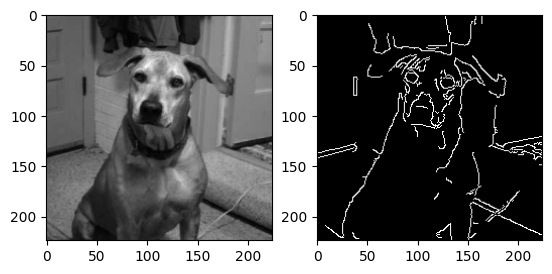

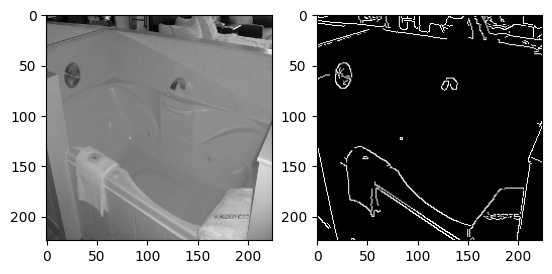

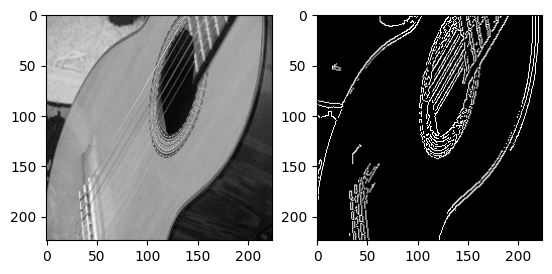

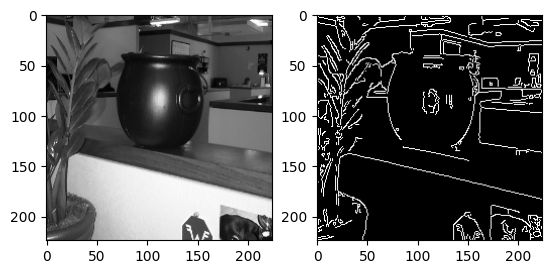

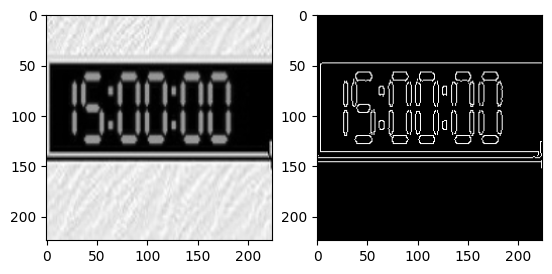

In [9]:
# view edged image
def view_edged_image(image_arrays, image_edge, n):
    """ View an image array """
    for i in range(0, n):
        plt.subplot(1, 2, 1)
        plt.imshow(image_arrays[i], cmap='gray')
        plt.subplot(1, 2, 2)
        plt.imshow(image_edge[i], cmap='gray')
        plt.show()

view_edged_image(train_images, train_edge_images, 5)

## 2) Machine Learning ##

In [10]:
# build a convolutional neural network (CNN) model
CNN = keras.Sequential([
        
])